<a href="https://colab.research.google.com/github/rg-smith/remote-sensing-hydro/blob/main/labs/lab5/lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab 5: Modeling deformation from changes in groundwater levels

In this lab, we will explore the relationship between changes in groundwater levels and aquifer deformation. The theory describing this relationship is described in great detail in section 2.1 of this paper: https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016WR019861. Read that section before completing this lab.

The general principle is that the stress experienced by sedimentary grains is equal to the pore pressure subtracted from the total overburden stress. When pore pressure decreases (equivalent to a decrease in groundwater level in pressurized aquifers), the effective stress increases. This can cause consolidation of aquifer materials. 

The amount of deformation that occurs is described simply with the following:

$\Delta$$b$=$\Delta$$h$$S_{sk}$$b_0$

Where $\Delta$$b$ is the deformation, $\Delta$$h$ is the change in groundwater level (head), $S_{sk}$ is the skeletal specific storage, and $b_0$ is the thickness of the material that is compacting.

Thus, if we know the change in head at any location in an aquifer, and the constant $S_{sk}$ relating the change in head to deformation, we can fairly simply calculate the deformation. There are two main challenges with implementing this. The first is that we *don't* know the change in head everywhere in the aquifer. In particular, clay layers within an aquifer or adjacent to it are the most compressible and thus have the largest deformation signal. These layers can experience significant changes in head, but it has a delayed response to the change in head experienced in an aquifer. We can model this using Equation 10 from the above referenced paper.

The other main challenge is that $S_{sk}$ is not constant with time. This parameter changes when inelastic deformation occurs. This happens when the head drops below the lowest head that has been previously experienced. This value can be challenging to estimate unless we have a long time series of head at a well, and can also accurately model the change in head in less permeable clay layers. 

The code implemented below will work reasonably well for simulating deformation with *known* aquifer head if the head record is sufficiently long.

First, we will import the necessary functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Now we will define a function. This is the deformation model. It takes as input an array with the time, another array of the same length with the head in the aquifer, vertical hydraulic conductivity (Kv), the skeletal specific storage during inelastic deformation (Sskv), during elastic deformation (Sske), the thickness of the clay layer being simulated, and the number of clay layers with that thickness being simulated.


In [2]:
def calc_deformation(time,head,Kv,Sskv,Sske,claythick,nclay,sandthick=-1,Nt_const=70): # this calculates deformation for a single clay layer of user=defined thickness
    # Use whatever units for time and length as desired, but they need to stay consistent
    # time - a vector of same lenght as head with the times that head measurements are taken. Numeric (years or days, typically)
    # head - a vector of same length as time with head measurements.
    # Kv - vertical hydraulic conductivity
    # Sske - Skeletal specific storage (elastic)
    # Sskv - skeletalt specific storage (inelastic)
    # clay_thick - thickness of single clay layer modeled
    # nclay - number of clay layers
    # sandthick - total thickness of sand. If negative, assume that sand thickness = clay thickness
    # t - vector containing the time at each time step. Needs to be sampled very dense. A dt of around 0.1 days usually is sufficient
    # Nz - number of layers in z direction, within the single clay layer modeled. Higher Nz requires higher dt, and vice versa

    # outputs are interpolated time, total surface deformation, interpolated head, and inelastic surface deformation

    Sske_sand_mult=0.5 # assuem sand sske 
    Sske_sand=Sske*Sske_sand_mult
    if sandthick<0:
        sand_thick=nclay*claythick
    else:
        sand_thick=sandthick
    Ske_sand=Sske_sand*sand_thick
    
    D=Kv/Sske
    num_yrs=time[-1]-time[0]
    Nz=5 # discretization of clay layer. Higher discretization in z requires higher discretization in time (longer simulation)
    
    clay_thick=claythick/2 # simulate doubly draining clay
    z = np.linspace(0, clay_thick, Nz+2)    # mesh points in space
    dz = clay_thick/Nz
    dz_full=np.ones(np.shape(z))*dz;dz_full[0]=dz/2;dz_full[-1]=dz/2
    tau=np.square(claythick/2)*Sske/Kv
    
    if tau<.1: # assume instantaneous equilibration of clay if tau <.1
        D=Kv/Sskv
        Nt=int(num_yrs*24+D*Nt_const) # set optimum number of time steps based on diffusivity. Minimum number is 4 per year
        t=np.linspace(time[0],time[-1],int(Nt+1))

        boundary=np.interp(t,time,head)

        dt = t[1] - t[0]
        h = boundary[0]*np.ones((Nz+2,Nt+1))  
        h[0,:]=boundary
        
        precons_head=h[:,0].copy()
    
        deformation=np.zeros(np.shape(h))
        deformation_v=np.zeros(np.shape(h))
        
        for n in range(0, Nt):
            # Compute u at inner mesh points
            for i in range(1, Nz+1):
                dz1=dz/(int(i==1)+1)
                dz2=dz
                dz_all=np.mean([dz1,dz2])
                h_new = h[0,n+1]
                dh=(h_new-h[i,n])
                defm=dh*Sske*dz*2
                deformation_v[i,n+1]=deformation_v[i,n]
                if np.logical_and(h_new<precons_head[i],dh<0): # if head drops below preconsolidation head, then Ss changes to Sskv
                    h_new = h[i,n] + ((Kv/Sskv)*dt/dz_all)*((h[i-1,n] - h[i,n])/dz1+( - h[i,n] + h[i+1,n])/dz2)
                    precons_head[i]=h_new
                    dh=(h_new-h[i,n])
                    defm=dh*Sskv*dz*2
                    deformation_v[i,n+1]=defm+np.min(deformation_v[i,0:(n+1)])
                h[i,n+1]=h_new
                deformation[i,n+1]=defm+deformation[i,n]
            h[-1,n+1]=h_new
    else:    
        Nt=int(num_yrs*24+D*Nt_const) # set optimum number of time steps based on diffusivity. Minimum number is 4 per year

        t=np.linspace(time[0],time[-1],int(Nt+1))

        boundary=np.interp(t,time,head)

        dt = t[1] - t[0]
        h = boundary[0]*np.ones((Nz+2,Nt+1))  
        h[0,:]=boundary
        
        precons_head=h[:,0].copy()
    
        deformation=np.zeros(np.shape(h))
        deformation_v=np.zeros(np.shape(h))
        
        for n in range(0, Nt):
            # Compute u at inner mesh points
            for i in range(1, Nz+1):
                dz1=dz/(int(i==1)+1)
                dz2=dz
                dz_all=np.mean([dz1,dz2])
                h_new = h[i,n] + ((Kv/Sske)*dt/dz_all)*((h[i-1,n] - h[i,n])/dz1+( - h[i,n] + h[i+1,n])/dz2)
                dh=(h_new-h[i,n])
                defm=dh*Sske*dz*2
                deformation_v[i,n+1]=deformation_v[i,n]
                if np.logical_and(h_new<precons_head[i],dh<0): # if head drops below preconsolidation head, then Ss changes to Sskv
                    h_new = h[i,n] + ((Kv/Sskv)*dt/dz_all)*((h[i-1,n] - h[i,n])/dz1+( - h[i,n] + h[i+1,n])/dz2)
                    precons_head[i]=h_new
                    dh=(h_new-h[i,n])
                    defm=dh*Sskv*dz*2
                    deformation_v[i,n+1]=defm+np.min(deformation_v[i,0:(n+1)])
                h[i,n+1]=h_new
                deformation[i,n+1]=defm+deformation[i,n]
            h[-1,n+1]=h_new
    deformation=np.sum(deformation,axis=0)*nclay
    deformation_v=np.sum(deformation_v,axis=0)*nclay
    boundary0=boundary-boundary[0]
    deformation=deformation+boundary0*Ske_sand
    return(t,deformation,boundary,deformation_v)

Now we will make some synthetic (read: fake) head data and simulate deformation with it. First, the synthetic data:

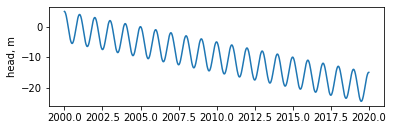

In [20]:
# Example problem
# Generate synthetic head data with seasonal trend
t=np.linspace(2000,2020,1000)
head=(t-t[0])*-1+5*np.cos(np.pi*2*t)

plt.figure();plt.subplot(2,1,1)
plt.plot(t,head);plt.ylabel('head, m')

Now we'll define the necessary input parameters, run a simulation and plot the results. Take a few minutes here to try changing different values (Kv, Sskv, Sske, nclay and claythick) to see what effect they have on the modeled output. What do you notice about the difference between Sskv and Sske? What would happen if they were equal to each other or very similar? Also comment on the difference between inelastic and elastic deformation.

Take a few screenshots with the parameters included of at least five different simulations and comment on how different parameters affect the overall output.

Text(0.5, 0, 'time, yr')

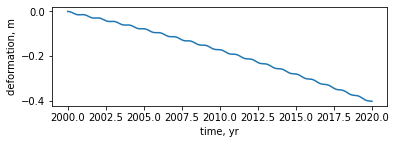

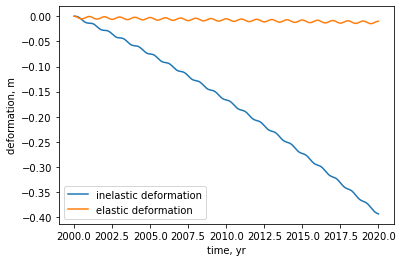

In [35]:
Kv=5E-5 # m/yr
Sskv=1E-3 #m-1
Sske=1E-5 #m-1
nclay=10
claythick=10 # m

# run simulation
t,defm,head,defm_v=calc_deformation(t,head,Kv,Sskv,Sske,claythick,nclay)

# plot results
plt.subplot(2,1,2);plt.plot(t,defm);
plt.ylabel('deformation, m')
plt.xlabel('time, yr')

plt.figure();plt.plot(t,defm_v);plt.plot(t,defm-defm_v);
plt.legend(['inelastic deformation','elastic deformation'])
plt.ylabel('deformation, m')
plt.xlabel('time, yr')

Now we will make some synthetic InSAR data. We are basically taking the deformation data, then adding some noise to give a realistic idea of what InSAR data might look like if it was collected over this area.

In [25]:
# sample deformation data to mimic InSAR data
InSAR_time=np.linspace(2015,2020,100)
InSAR=np.interp(InSAR_time,t,defm)
# add noise
InSAR=InSAR+np.random.normal(loc=0,scale=0.01,size=InSAR.shape)

plt.figure();plt.plot(t,defm);
plt.ylabel('deformation, m')
plt.xlabel('time, yr')
plt.scatter(InSAR_time,InSAR,s=1,c='r')

Next we will assume that we have the head record in the aquifer, and the InSAR data, but have no idea what the true aquifer/clay layer properties are. We will run a parameter estimation process that attempts to match the observed InSAR data using our model, tweaking the input parameters until it matches.

You'll want to use starting parameters that are within the ballpark of the parameters you selected for your model. Note that we are assuming here that the clay layer thickness is 5 m, and we know that. That's sort of a big assumption, but we're doing it to simplify the problem because solving for this many parameters is quite tricky. So make sure that your model that you ran most recently in the above code has a clay layer thickness of 5 m.

This part will probably take a few minutes. You should see a summary every so often popping up with the parameter values and rmse (root mean squared error) of your latest model output. The rmse should be steadily going down.

In [38]:
def calc_residual(x):
    time,defm,_,_=calc_deformation(t,head,10**x[0],10**x[1],10**x[2],10,5)
    mod_def=np.interp(InSAR_time,time,defm)
    residual=mod_def-InSAR
    rmse=np.sqrt(np.mean(np.square(residual)))
    if np.random.uniform()>0.95: # print results every 20 iterations (roughly)
      print('paramters: '+str(x))
      print('root mean squared error: '+str(rmse))
    return(rmse)

In [ ]:
# invert to solve for parameters
from scipy.optimize import minimize
initial_parameters=[-5,-3.5,-5.5] # I use logarithm of Kv, Sskv, Sske for inversion so it's more stable
parameters=minimize(calc_residual,initial_parameters,options={'maxiter':3}) # setting the maximum iterations to a low number so it doesn't take forever

# simulate with inverted parameter estimates
tmod,defm_mod,head_mod,defm_v_mod=calc_deformation(t,head,10**parameters.x[0],
                                                   10**parameters.x[1],10**parameters.x[2],
                                                   10,5)



Now plot your results. Comment on how well your estimated deformation matched the true deformation. Was it a perfect match? Why or why not?

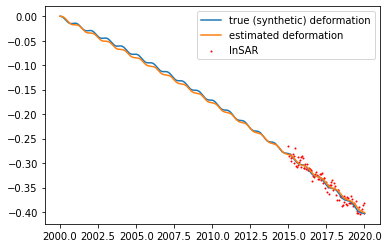

In [45]:
# compare with synthetic 'true' data
plt.figure();plt.plot(t,defm);plt.plot(tmod,defm_mod);
plt.scatter(InSAR_time,InSAR,s=1,c='r')
plt.legend(['true (synthetic) deformation','estimated deformation','InSAR'])